In [1]:
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import scipy
import numpy as np
import anndata
import h5py
import tqdm
from os.path import join as pjoin
import snapatac2 as snap
import pybedtools
import anndata as ad
import scanpy as sc

root_directory = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_inGMSTR'


### subsetting 3_clusters_inGMSTR h5ads from concatenated.h5ads 

In [3]:
## atac data
root_directory2 = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup'
file_path = os.path.join(root_directory2, 'concatenated.h5ads') #same as "../h5ad/concatenated.h5ads"
data = snap.read_dataset(file_path, mode='r+')
data.obs_names = data.adatas.obs["ar_cellname"]


## astro and full human snRNA metadata
adata3 = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/HMBA_human_Astro_3subGroups_forPyNb.h5ad")
target_clusters = ["Human-14", "Human-7", "Human-31"]
astro_adata = adata3[adata3.obs["Cluster"].isin(target_clusters)].copy()
astro_adata.obs["Cluster"] = pd.Categorical(astro_adata.obs["Cluster"], categories=target_clusters, ordered=True)


with h5py.File("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/Human/BasalGanglia/Human_basalganglia_AIBS_BICAN.h5ad") as f:
    metadata = anndata.experimental.read_elem(f['obs'])
metadata = metadata.drop_duplicates(subset=["ar_id"]).reset_index(drop=True)

# Check if each barcoded_cell_sample_label maps to only one ar_id
mapping_check = metadata.drop_duplicates(subset=["barcoded_cell_sample_label", "ar_id"])
# If the count of unique barcoded_cell_sample_label equals the row count, it's one-to-one
is_unique = mapping_check["barcoded_cell_sample_label"].nunique() == len(mapping_check)
print(f"Is one-to-one mapping: {is_unique}")


# build the mapping from barcoded_cell_sample_label → ar_id
id_map = dict(zip(metadata["barcoded_cell_sample_label"], metadata["ar_id"]))

# parse cell_barcode and barcoded_cell_sample_label from current obs_names
cb = astro_adata.obs["cell_barcode"]
bsl = astro_adata.obs["barcoded_cell_sample_label"]
new_names = [f"{c}-{id_map.get(s, s)}" for c, s in zip(cb, bsl)]

# update obs_names
astro_adata.obs_names = new_names
astro_adata.obs["ar_cellname"] = astro_adata.obs_names
assert astro_adata.obs_names.is_unique, "obs_names are not unique!"

## Merge rna and atac
common_cells = list(set(data.obs_names).intersection(set(astro_adata.obs_names)))
print(len(common_cells))

## Build a subset of the concatenated ATAC data, this creates a new file and directory
adata_subset = data.subset(common_cells, out=root_directory)[0] #, out="_subset_Astro" #output file "astro_atac.h5ads"

## obs col. annotations
adata_subset.obs["Cluster"] = astro_adata.obs.loc[adata_subset.obs_names, "Cluster"].str.replace(" ", "_")
adata_subset.obs["subGroup"] = astro_adata.obs.loc[adata_subset.obs_names, "subGroup"].str.replace(" ", "_")
adata_subset.obs["anatomical_region"] = astro_adata.obs.loc[adata_subset.obs_names, "anatomical_region"].str.replace(" ", "_")
adata_subset.obs["anatomical_region_merged"] = astro_adata.obs.loc[adata_subset.obs_names, "anatomical_region_merged"].str.replace(" ", "_")
adata_subset.obs["donor_id"] = astro_adata.obs.loc[adata_subset.obs_names, "donor_id"].str.replace(" ", "_")

data.close() ## Close the full ATAC file as we don't need it anymore
adata_subset.close()


/scratch/fast/2346252/ipykernel_948645/3656560006.py:5: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  data.obs_names = data.adatas.obs["ar_cellname"]


Is one-to-one mapping: True
59506


### subsetting 3_cluster peaks from 21_astro_clusters_peaks_file

In [2]:
### https://github.com/AllenInstitute/HMBA_Genomics/blob/main/BasalGanglia/Human/ATAC/Astro/snapatac_tobigwig.py #already ran snapATAC2 per cluster for human BG astro.
#### bigwigs: /allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro/Cluster_bigwig_TSSnorm/Human-*.bw
#### peaks: /allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro/Cluster_bigwig_TSSnorm/merged_peaks.bed & Cluster_by_peaks.csv

In [3]:
orig_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro/Cluster_bigwig_TSSnorm/"
df_all = pd.read_csv(os.path.join(orig_path,"Cluster_by_peaks.csv"))

target_clusters = ['Human-14', 'Human-7', 'Human-31']
df_target = df_all[df_all[target_clusters].any(axis=1)]
df_target = df_target[["Peaks"] + target_clusters]
df_target.to_csv(orig_path + "astro_GMSTR_3clusters_by_peaks.csv", index=False)


# bed file
df_bed = df_target["Peaks"].str.split(":|-", expand=True)
df_bed.columns = ["chrom", "start", "end"]
df_bed.to_csv(orig_path + "astro_GMSTR_3clusters_merged_peaks.bed", sep="\t", header=False, index=False)

In [4]:
df_target

,Peaks,Human-14,Human-7,Human-31
1,GL000194.1:21905-22406,True,False,False
3,GL000194.1:24960-25461,True,True,True
4,GL000194.1:24260-24761,True,False,True
5,GL000194.1:26320-26821,True,False,False
6,GL000194.1:28126-28627,True,True,True
...,...,...,...,...
413033,chrY:56869961-56870462,True,False,False
413034,chrY:56870724-56871225,True,True,True
413036,chrY:56872717-56873218,True,False,False
413037,chrY:56873616-56874117,True,False,False


### call DARs

In [2]:
adata = snap.read_dataset(root_directory + "/_dataset.h5ads") # only 3 clusters cells
peaks = pd.read_csv(root_directory + "/astro_GMSTR_3clusters_by_peaks.csv")

In [3]:
%%time
peak_mat = snap.pp.make_peak_matrix(adata, use_rep=peaks['Peaks'], counting_strategy="insertion") ## peak_file="your_bed_file_.bed"
print(peak_mat.obs['Cluster'].value_counts())
peak_mat.write_h5ad(root_directory + "/astro_3clustersinGMSTR_peak_mat_Insertion.h5ad")
peak_mat

/home/yuanyuan.fu/bin/miniconda3/envs/human_bg_atac/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'sample' as categorical
... storing 'Group' as categorical
... storing 'Cluster' as categorical
... storing 'subGroup' as categorical
... storing 'anatomical_region' as categorical
... storing 'anatomical_region_merged' as categorical
... storing 'donor_id' as categorical


Cluster
Human-14    54688
Human-31     3030
Human-7      1788
Name: count, dtype: int64
CPU times: user 24min 18s, sys: 1min 47s, total: 26min 5s
Wall time: 8min 45s


AnnData object with n_obs × n_vars = 59506 × 320189
    obs: 'sample', 'Group', 'Cluster', 'subGroup', 'anatomical_region', 'anatomical_region_merged', 'donor_id'

<Figure size 1000x600 with 0 Axes>

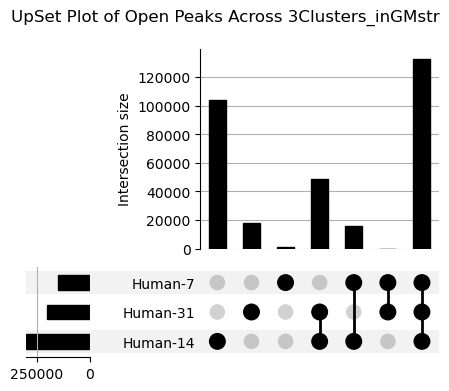

In [4]:
from upsetplot import from_indicators, UpSet
import matplotlib.pyplot as plt

data = from_indicators(indicators=["Human-14", "Human-7", "Human-31"], data=peaks)

plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count").plot()
plt.suptitle("UpSet Plot of Open Peaks Across 3Clusters_inGMstr")
plt.show()


In [5]:
%%time

group1 = "Human-14"
group2 = "Human-7"

## peak set selection (open peaks per subGroup)
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

## cell selection
h14 = peak_mat.obs['Cluster'] == group1
h7 = peak_mat.obs['Cluster'] == group2

h14_h7_diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=h14,
    cell_group2=h7,
    features=peaks_selected,
    min_log_fc=0.5, ## 0.25 by default; logFC 0.585 = FC 1.5
    min_pct=0.1, ## 0.05 by default
)

import polars as pl
h14_h7_diff_peaks = h14_h7_diff_peaks.filter(pl.col('adjusted p-value') < 0.05)
h14_h7_diff_peaks.write_csv(root_directory + "/H14_vs_H7_diff_peaks_logfc0.5_pct0.1_padj0.05.csv")
print(h14_h7_diff_peaks.head())

2025-07-30 10:23:26 - INFO - Input contains 302582 features, now perform filtering with 'min_log_fc = 0.5' and 'min_pct = 0.1' ...
2025-07-30 10:24:06 - INFO - Testing 1494 features ...
100%|██████████| 1494/1494 [29:03<00:00,  1.17s/it]

shape: (5, 4)
┌───────────────────────────┬───────────────────┬─────────────┬──────────────────┐
│ feature name              ┆ log2(fold_change) ┆ p-value     ┆ adjusted p-value │
│ ---                       ┆ ---               ┆ ---         ┆ ---              │
│ str                       ┆ f64               ┆ f64         ┆ f64              │
╞═══════════════════════════╪═══════════════════╪═════════════╪══════════════════╡
│ chr14:101457846-101458347 ┆ -1.683961         ┆ 1.1429e-109 ┆ 1.7075e-106      │
│ chr19:8592347-8592848     ┆ -1.439825         ┆ 5.7359e-99  ┆ 4.2847e-96       │
│ chr14:101458777-101459278 ┆ -1.635981         ┆ 3.5785e-88  ┆ 1.7821e-85       │
│ chr14:59919836-59920337   ┆ -1.939679         ┆ 1.7448e-86  ┆ 6.5169e-84       │
│ chr14:101457202-101457703 ┆ -1.704298         ┆ 2.1805e-82  ┆ 6.5154e-80       │
└───────────────────────────┴───────────────────┴─────────────┴──────────────────┘
CPU times: user 1h 9min 31s, sys: 47min 18s, total: 1h 56min 49s
Wall tim

In [6]:
%%time

group1 = "Human-14"
group2 = "Human-31"

## peak set selection (open peaks per subGroup)
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

## cell selection
h14 = peak_mat.obs['Cluster'] == group1
h31 = peak_mat.obs['Cluster'] == group2

h14_h31_diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=h14,
    cell_group2=h31,
    features=peaks_selected,
    min_log_fc=0.5, ## 0.25 by default; logFC 0.585 = FC 1.5
    min_pct=0.1, ## 0.05 by default
)

import polars as pl
h14_h31_diff_peaks = h14_h31_diff_peaks.filter(pl.col('adjusted p-value') < 0.05)
h14_h31_diff_peaks.write_csv(root_directory + "/H14_vs_H31_diff_peaks_logfc0.5_pct0.1_padj0.05.csv")
print(h14_h31_diff_peaks.head())

2025-07-30 10:53:44 - INFO - Input contains 319248 features, now perform filtering with 'min_log_fc = 0.5' and 'min_pct = 0.1' ...
2025-07-30 10:54:27 - INFO - Testing 8585 features ...
100%|██████████| 8585/8585 [2:39:40<00:00,  1.12s/it]  

shape: (5, 4)
┌──────────────────────────┬───────────────────┬─────────────┬──────────────────┐
│ feature name             ┆ log2(fold_change) ┆ p-value     ┆ adjusted p-value │
│ ---                      ┆ ---               ┆ ---         ┆ ---              │
│ str                      ┆ f64               ┆ f64         ┆ f64              │
╞══════════════════════════╪═══════════════════╪═════════════╪══════════════════╡
│ chr6:34244477-34244978   ┆ -2.69657          ┆ 1.1421e-243 ┆ 9.8049e-240      │
│ chr5:132263860-132264361 ┆ -3.196385         ┆ 6.7311e-241 ┆ 2.8893e-237      │
│ chr1:1201302-1201803     ┆ -3.310109         ┆ 9.6748e-226 ┆ 2.7686e-222      │
│ chr12:52874113-52874614  ┆ -3.033955         ┆ 7.2369e-219 ┆ 1.5532e-215      │
│ chr6:25504662-25505163   ┆ -3.564447         ┆ 3.8902e-207 ┆ 6.6795e-204      │
└──────────────────────────┴───────────────────┴─────────────┴──────────────────┘
CPU times: user 6h 3min 3s, sys: 4h 30min 32s, total: 10h 33min 35s
Wall time: 2h 40

In [7]:
%%time

group1 = "Human-31"
group2 = "Human-7"

## peak set selection (open peaks per subGroup)
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

## cell selection
h31 = peak_mat.obs['Cluster'] == group1
h7 = peak_mat.obs['Cluster'] == group2

h31_h7_diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=h31,
    cell_group2=h7,
    features=peaks_selected,
    min_log_fc=0.5, ## 0.25 by default; logFC 0.585 = FC 1.5
    min_pct=0.1, ## 0.05 by default
)

import polars as pl
h31_h7_diff_peaks = h31_h7_diff_peaks.filter(pl.col('adjusted p-value') < 0.05)
h31_h7_diff_peaks.write_csv(root_directory + "/H31_vs_H7_diff_peaks_logfc0.5_pct0.1_padj0.05.csv")
print(h31_h7_diff_peaks.head())

2025-07-30 13:34:13 - INFO - Input contains 216247 features, now perform filtering with 'min_log_fc = 0.5' and 'min_pct = 0.1' ...
2025-07-30 13:34:34 - INFO - Testing 11680 features ...
100%|██████████| 11680/11680 [1:55:54<00:00,  1.68it/s] 

shape: (5, 4)
┌───────────────────────────┬───────────────────┬─────────────┬──────────────────┐
│ feature name              ┆ log2(fold_change) ┆ p-value     ┆ adjusted p-value │
│ ---                       ┆ ---               ┆ ---         ┆ ---              │
│ str                       ┆ f64               ┆ f64         ┆ f64              │
╞═══════════════════════════╪═══════════════════╪═════════════╪══════════════════╡
│ chr2:44937656-44938157    ┆ -2.959686         ┆ 9.3252e-125 ┆ 1.0892e-120      │
│ chr1:37476461-37476962    ┆ 4.10833           ┆ 1.0965e-108 ┆ 6.4033e-105      │
│ chr8:142451781-142452282  ┆ -2.567217         ┆ 4.2055e-99  ┆ 1.6373e-95       │
│ chr14:101458777-101459278 ┆ -2.83946          ┆ 4.2100e-98  ┆ 1.2293e-94       │
│ chr6:34244477-34244978    ┆ 3.380369          ┆ 1.1676e-92  ┆ 2.7274e-89       │
└───────────────────────────┴───────────────────┴─────────────┴──────────────────┘
CPU times: user 4h 45min 2s, sys: 2h 52min 12s, total: 7h 37min 15s
Wall 

In [8]:
file_info = {
    "H14_vs_H7_diff_peaks_logfc0.5_pct0.1_padj0.05.csv": "H14_vs_H7",
    "H14_vs_H31_diff_peaks_logfc0.5_pct0.1_padj0.05.csv": "H14_vs_H31",
    "H31_vs_H7_diff_peaks_logfc0.5_pct0.1_padj0.05.csv": "H31_vs_H7",
}

# to save all dfs
dfs = []

for fname, label in file_info.items():
    fpath = os.path.join(root_directory, fname)
    df = pd.read_csv(fpath)
    df["comparison"] = label  
    dfs.append(df)


merged_df = pd.concat(dfs, ignore_index=True)
print(merged_df.head())

                feature name  log2(fold_change)        p-value  \
0  chr14:101457846-101458347          -1.683961  1.142885e-109   
1      chr19:8592347-8592848          -1.439825   5.735897e-99   
2  chr14:101458777-101459278          -1.635981   3.578500e-88   
3    chr14:59919836-59920337          -1.939679   1.744822e-86   
4  chr14:101457202-101457703          -1.704298   2.180531e-82   

   adjusted p-value comparison  
0     1.707470e-106  H14_vs_H7  
1      4.284715e-96  H14_vs_H7  
2      1.782093e-85  H14_vs_H7  
3      6.516910e-84  H14_vs_H7  
4      6.515425e-80  H14_vs_H7  


In [9]:
unique_peak_count = merged_df["feature name"].nunique()
print("Number of unique peaks:", unique_peak_count)


Number of unique peaks: 13171


In [10]:
### universe set of DARs (merge 3 1v1 files) -> save to bed
unique_peaks = merged_df["feature name"].unique()


bed_df = pd.DataFrame([x.replace('"','') for x in unique_peaks])  
bed_df = bed_df[0].str.extract(r'(?P<chr>[^:]+):(?P<start>\d+)-(?P<end>\d+)')

bed_df["start"] = bed_df["start"].astype(int)
bed_df["end"] = bed_df["end"].astype(int)


bed_df[["chr", "start", "end"]].to_csv(root_directory + "/unique_DAR_peaks_humanAstro_3Clusters_inGMSTR.bed", sep="\t", header=False, index=False)

print("BED file saved as unique_peaks.bed")

BED file saved as unique_peaks.bed


In [ ]:
#   8586 H14_vs_H31_diff_peaks_logfc0.5_pct0.1_padj0.05.csv
#   1495 H14_vs_H7_diff_peaks_logfc0.5_pct0.1_padj0.05.csv
#   11681 H31_vs_H7_diff_peaks_logfc0.5_pct0.1_padj0.05.csv
#  13171 unique_DAR_peaks_humanAstro_3Clusters_inGMSTR.bed

### Visualization of DAR peaks

In [11]:
unique_peak_count = merged_df["feature name"].nunique()
print("Number of unique peaks:", unique_peak_count)


Number of unique peaks: 13171


<Figure size 1000x600 with 0 Axes>

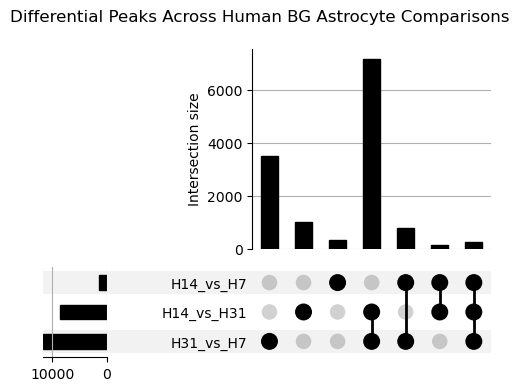

In [12]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# summarize that each peak appears in which comparison
peak_to_comparisons = (
    merged_df.groupby("feature name")["comparison"]
    .apply(set)  
    .reset_index()
)

memberships = peak_to_comparisons["comparison"].tolist()
data = from_memberships(memberships)

plt.figure(figsize=(10, 6))
UpSet(data, subset_size="count").plot()
plt.suptitle("Differential Peaks Across Human BG Astrocyte Comparisons")
plt.show()
